# BANKING ANALYTICS - COURSEWORK 2 ON CREDIT RISK ANALYTICS

# 1. LOADING THE DATA


In [ ]:
!pip install scorecardpy

In [198]:
#Importing the required libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import scorecardpy as sc
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,precision_score,recall_score,auc,accuracy_score,roc_auc_score,f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns

In [199]:
#reading columnames
column_names = pd.read_excel('CC_VariablesList.XLS')['Var_Title']

In [200]:
#reading data and adding column names
cards_data = pd.read_csv("CC_Modeling_Data.txt",delimiter="\t",encoding="latin1", names=list(column_names))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (51,52) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [201]:
cards_data.head().iloc[:,:8]

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS
0,1,C,5,Web,0,1,F,6
1,2,C,15,Carga,0,1,F,2
2,3,C,5,Web,0,1,F,2
3,4,C,20,Web,0,1,F,2
4,5,C,10,Web,0,1,M,2


In [202]:
cards_data.describe()

,ID_CLIENT,PAYMENT_DAY,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,NACIONALITY,RESIDENCE_TYPE,MONTHS_IN_RESIDENCE,FLAG_EMAIL,PERSONAL_MONTHLY_INCOME,OTHER_INCOMES,FLAG_VISA,FLAG_MASTERCARD,FLAG_DINERS,FLAG_AMERICAN_EXPRESS,FLAG_OTHER_CARDS,QUANT_BANKING_ACCOUNTS,QUANT_SPECIAL_BANKING_ACCOUNTS,PERSONAL_ASSETS_VALUE,QUANT_CARS,MONTHS_IN_THE_JOB,PROFESSION_CODE,OCCUPATION_TYPE,MATE_PROFESSION_CODE,MATE_EDUCATION_LEVEL,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,AGE,TARGET_LABEL_BAD=1
count,50000.000000,50000.000000,50000.0,50000.000000,50000.00000,50000.000000,50000.0,50000.000000,48651.000000,46223.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,42244.000000,42687.000000,21116.000000,17662.000000,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.00000,50000.000000
mean,25000.500000,12.869920,0.0,1.006540,2.14840,0.650520,0.0,0.961600,1.252225,9.727149,0.802280,886.678437,35.434760,0.111440,0.097460,0.001320,0.001740,0.002040,0.357840,0.357840,2.322372e+03,0.336140,0.009320,8.061784,2.484316,3.797926,0.296003,0.0,0.0,0.0,0.0,1.275700,43.24852,0.260820
std,14433.901067,6.608385,0.0,0.080606,1.32285,1.193655,0.0,0.202105,0.867833,10.668841,0.398284,7846.959327,891.515142,0.314679,0.296586,0.036308,0.041677,0.045121,0.479953,0.479953,4.235798e+04,0.472392,0.383453,3.220104,1.532261,5.212168,0.955688,0.0,0.0,0.0,0.0,0.988286,14.98905,0.439086
min,1.000000,1.000000,0.0,1.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,6.00000,0.000000
25%,12500.750000,10.000000,0.0,1.000000,1.00000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,360.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,31.00000,0.000000
50%,25000.500000,10.000000,0.0,1.000000,2.00000,0.000000,0.0,1.000000,1.000000,6.000000,1.000000,500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,9.000000,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,41.00000,0.000000
75%,37500.250000,15.000000,0.0,1.000000,2.00000,1.000000,0.0,1.000000,1.000000,15.000000,1.000000,800.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,9.000000,4.000000,11.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,53.00000,1.000000
max,50000.000000,25.000000,0.0,2.000000,7.00000,53.000000,0.0,2.000000,5.000000,228.000000,1.000000,959000.000000,194344.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,6.000000e+06,1.000000,35.000000,18.000000,5.000000,17.000000,5.000000,0.0,0.0,0.0,0.0,7.000000,106.00000,1.000000


In [203]:
cards_data.shape #Has 53 cardholder characteristic features and label field 

(50000, 54)

# 2. DATA CLEANING

## 2.1. ALL ENTRIES 0

In [204]:
#All entries are zeros for these fields hence can be removed.
all_zero_vars = ['QUANT_ADDITIONAL_CARDS','EDUCATION_LEVEL','FLAG_HOME_ADDRESS_DOCUMENT','FLAG_RG','FLAG_CPF','FLAG_INCOME_PROOF']

In [205]:
cards_data.describe() [all_zero_vars]

,QUANT_ADDITIONAL_CARDS,EDUCATION_LEVEL,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0


In [206]:
for i in all_zero_vars:
  print(pd.value_counts(cards_data[i]))

0    50000
Name: QUANT_ADDITIONAL_CARDS, dtype: int64
0    50000
Name: EDUCATION_LEVEL, dtype: int64
0    50000
Name: FLAG_HOME_ADDRESS_DOCUMENT, dtype: int64
0    50000
Name: FLAG_RG, dtype: int64
0    50000
Name: FLAG_CPF, dtype: int64
0    50000
Name: FLAG_INCOME_PROOF, dtype: int64


In [207]:
cards_data.drop(all_zero_vars,axis=1,inplace=True)

## 2.2. ALL ENTRIES SAME

In [208]:
#same values accross
one_category = ['CLERK_TYPE','FLAG_MOBILE_PHONE','FLAG_ACSP_RECORD']

In [209]:
cards_data.describe(include='object')[one_category]

,CLERK_TYPE,FLAG_MOBILE_PHONE,FLAG_ACSP_RECORD
count,50000,50000,50000
unique,1,1,1
top,C,N,N
freq,50000,50000,50000


In [210]:
for i in one_category:
  print(pd.value_counts(cards_data[i]))

C    50000
Name: CLERK_TYPE, dtype: int64
N    50000
Name: FLAG_MOBILE_PHONE, dtype: int64
N    50000
Name: FLAG_ACSP_RECORD, dtype: int64


In [211]:
cards_data.drop(one_category,axis=1,inplace=True)

In [212]:
cards_data.shape # after dropping features in steps 2.1 and 2.2

(50000, 45)

## 2.3. TRANSFORMATION OF VARIABLES

#### 2.3.1. VARIABLE FOR NUMBER OF CREDIT CARDS HELD


In [213]:
cards_data['number_of_cards'] = cards_data[["FLAG_VISA","FLAG_MASTERCARD","FLAG_DINERS","FLAG_AMERICAN_EXPRESS","FLAG_OTHER_CARDS"]].sum(axis=1)

#### 2.3.2. INCOME PER FAMILY MEMBER


In [214]:
cards_data['income_per_familymember'] = (cards_data['PERSONAL_MONTHLY_INCOME']+cards_data['OTHER_INCOMES'])/(cards_data['QUANT_DEPENDANTS']+1)


#### 2.3.3. LOW INCOME PROFESSIONAL LOCATION BUT HIGH INCOME RESIDENCE LOCATION (Note useful as PIN is exactly same for professional and residence)

In [215]:
cards_data['RESIDENCIAL_ZIP_3'] = cards_data['RESIDENCIAL_ZIP_3']
cards_data['PROFESSIONAL_ZIP_3'] = cards_data['PROFESSIONAL_ZIP_3']
high_income_zip = cards_data.groupby(['PROFESSIONAL_ZIP_3']).agg({'PERSONAL_MONTHLY_INCOME':pd.Series.mean,'ID_CLIENT':pd.Series.count}).sort_values(by='PERSONAL_MONTHLY_INCOME',ascending=False)
high_income_zip_groupby = high_income_zip[high_income_zip['ID_CLIENT']>50].head(32)
HIGH_INCOME_areas = high_income_zip_groupby.index.to_list()

In [216]:
def check_expenditure_activity(residence,profession):
  if residence!=profession:
    print(residence,profession,HIGH_INCOME_areas)
  if residence in HIGH_INCOME_areas and profession not in HIGH_INCOME_areas and profession!=None:
    return 0
  elif residence not in HIGH_INCOME_areas and profession in HIGH_INCOME_areas and profession!=None:
    return 2
  else:
    return 1

In [217]:
cards_data['expenditure_location'] = cards_data.apply(lambda row: check_expenditure_activity(row['RESIDENCIAL_ZIP_3'],row['PROFESSIONAL_ZIP_3']),axis=1)

In [218]:
cards_data.drop(['expenditure_location'],axis=1,inplace=True)

#### 2.3.4. HIGH INCOME NEIGHBOURHOOD

In [219]:
def high_income_neighbourhood(residence):
  if residence in HIGH_INCOME_areas:
    return 1
  else:
    return 0

In [220]:
cards_data['high_income_neighbourhood'] = cards_data.apply(lambda row: high_income_neighbourhood(row['RESIDENCIAL_ZIP_3']),axis=1)


#### 2.3.5. PROFESSION AND RESIDENCE DIFFERENT

In [221]:
def diff_location_job(residence,profession):
  if residence!=profession:
    return 0
  else:
    return 1


In [222]:
cards_data['diff_job_location'] = cards_data.apply(lambda row: diff_location_job(row['RESIDENCIAL_STATE'],row['PROFESSIONAL_STATE']),axis=1)

#### 2.3.6. NUMBER OF ALL BANKING PRODUCTS


In [223]:
cards_data['number_of_products'] = cards_data[["number_of_cards","QUANT_BANKING_ACCOUNTS","QUANT_SPECIAL_BANKING_ACCOUNTS"]].sum(axis=1)

#### 2.3.7. EARNING ABILITY


In [224]:
bins = [0,17, 25, 35, 45, 55, 70, np.inf]

names = ['0-17','17-25', '25-35', '35-45', '45-55', '55-70', '70+']

cards_data['age_bracket']= pd.cut(cards_data['AGE'], bins, labels=names)

In [225]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [226]:
age_earning_brackets = cards_data.groupby(['age_bracket'],as_index=False).agg({'PERSONAL_MONTHLY_INCOME':[percentile(25),percentile(50),percentile(75)]})
age_earning_brackets.columns = ['_'.join(col).strip() for col in age_earning_brackets.columns.values]
age_earning_brackets

,age_bracket_,PERSONAL_MONTHLY_INCOME_percentile_25,PERSONAL_MONTHLY_INCOME_percentile_50,PERSONAL_MONTHLY_INCOME_percentile_75
0,0-17,350.0,400.0,466.00
1,17-25,360.0,437.0,596.94
2,25-35,381.0,500.0,752.00
3,35-45,388.0,543.0,869.54
4,45-55,380.0,576.0,986.00
5,55-70,350.0,423.0,800.00
6,70+,350.0,352.0,604.15


In [227]:
def earning_ability(income,age_bracket,df_summary_income=age_earning_brackets):
  perc25 = df_summary_income.loc[df_summary_income['age_bracket_']==age_bracket,'PERSONAL_MONTHLY_INCOME_percentile_25'].item()
  perc50 = df_summary_income[df_summary_income['age_bracket_']==age_bracket]['PERSONAL_MONTHLY_INCOME_percentile_50'].item()
  perc75 = df_summary_income[df_summary_income['age_bracket_']==age_bracket]['PERSONAL_MONTHLY_INCOME_percentile_75'].item()
  if income<=perc25:
    return 1
  elif (income>perc25) & (income<=perc50):
    return 2
  elif (income>perc50) & (income<=perc75):
    return 3
  elif income>perc75:
    return 4
  else:
    return 0

In [228]:
cards_data['earning_ability'] = cards_data.apply(lambda row: earning_ability(row['PERSONAL_MONTHLY_INCOME'],row['age_bracket']),axis=1)

In [229]:
#Transformation for professional ph,res ph,company flag
cards_data['FLAG_RESIDENCIAL_PHONE']= cards_data['FLAG_RESIDENCIAL_PHONE'].apply(lambda x: 1 if x=='Y' else 0)
cards_data['FLAG_PROFESSIONAL_PHONE']= cards_data['FLAG_PROFESSIONAL_PHONE'].apply(lambda x: 1 if x=='Y' else 0)
cards_data['COMPANY']= cards_data['COMPANY'].apply(lambda x: 1 if x=='Y' else 0) 

#Transformation for application submission flag
cards_data['APPLICATION_SUBMISSION_TYPE']= cards_data['APPLICATION_SUBMISSION_TYPE'].apply(lambda x: 1 if x=='Web' else (2 if x=='Carga' else 0))

In [230]:
cards_data.shape # adding created variables that could boost the machine performance.

(50000, 52)

## 2.4. REMOVING IDENTITY VARIABLES

In [231]:
#Ethics Based removal - Identity variables
identity_variables = ['ID_CLIENT','SEX','STATE_OF_BIRTH','CITY_OF_BIRTH','RESIDENCIAL_BOROUGH','RESIDENCIAL_ZIP_3','RESIDENCIAL_STATE','RESIDENCIAL_CITY','PROFESSIONAL_ZIP_3','PROFESSIONAL_BOROUGH','PROFESSIONAL_CITY','PROFESSIONAL_STATE','PROFESSIONAL_PHONE_AREA_CODE','RESIDENCIAL_PHONE_AREA_CODE']
cards_data.drop(identity_variables,axis=1,inplace=True)

In [232]:
cards_data.shape

(50000, 38)

## 2.5. MISSING DATA ANALYSIS

In [233]:
#There are blanks in the data. Replace blanks and spaces with Null
cards_data.replace(r'^\s*$', np.nan, regex=True,inplace=True)

In [234]:
percent_missing = cards_data.isnull().sum() * 100 / len(cards_data)
percent_missing.sort_values(ascending=False).head(7)

MATE_EDUCATION_LEVEL    64.676
MATE_PROFESSION_CODE    57.768
PROFESSION_CODE         15.512
OCCUPATION_TYPE         14.626
MONTHS_IN_RESIDENCE      7.554
RESIDENCE_TYPE           2.698
FLAG_DINERS              0.000
dtype: float64

In [235]:
# Removing variables with a lot of missing values
MISSING_VALUE_COLUMNS =  ['MATE_EDUCATION_LEVEL','MATE_PROFESSION_CODE']
cards_data.drop(MISSING_VALUE_COLUMNS,axis=1,inplace=True)

In [236]:
# NO USEFUL DATA
MEANINGLESS_COLUMNS =  ['MONTHS_IN_THE_JOB','age_bracket']
cards_data.drop(MEANINGLESS_COLUMNS,axis=1,inplace=True)

In [237]:
cards_data.shape

(50000, 34)

## 2.6. MISSING VALUE IMPUTATION


In [238]:
#Calculate percentage of missing values in each field.
percent_missing = cards_data.isnull().sum() * 100 / len(cards_data)
percent_missing.sort_values(ascending=False)[:5]

PROFESSION_CODE        15.512
OCCUPATION_TYPE        14.626
MONTHS_IN_RESIDENCE     7.554
RESIDENCE_TYPE          2.698
FLAG_MASTERCARD         0.000
dtype: float64

In [239]:
# Fill nulls with median/mode
for i,j in percent_missing.items():
  if j>0:
    if i=='MONTHS_IN_RESIDENCE':
      cards_data[i] = cards_data[i].fillna(cards_data[i].median())
    elif i in ['PROFESSION_CODE','OCCUPATION_TYPE','RESIDENCE_TYPE']:
      cards_data[i] = cards_data[i].fillna(100)
    else:
      cards_data[i] = cards_data[i].fillna(cards_data[i].mode())


In [240]:
cards_data.shape

(50000, 34)

## 2.7. OUTLIER TREATMENT


#### 2.7.1. DEPENDENTS

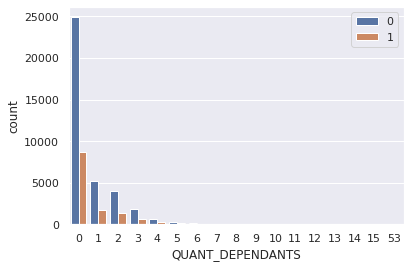

In [241]:
sns.set(color_codes=True)
sns.countplot(data = cards_data, x = "QUANT_DEPENDANTS", hue = "TARGET_LABEL_BAD=1")
plt.legend(loc='upper right')

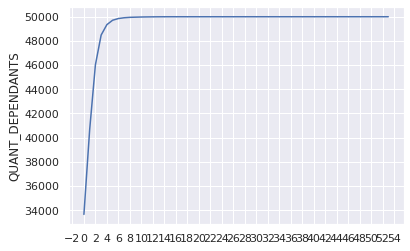

In [242]:
loc = plticker.MultipleLocator(base=2)
dep_cumsum = cards_data['QUANT_DEPENDANTS'].value_counts().sort_index().cumsum()
axes=sns.lineplot(x=dep_cumsum.index,y=dep_cumsum)
axes.xaxis.set_major_locator(loc)


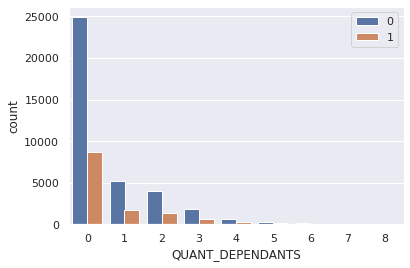

In [243]:
cards_data = cards_data.loc[cards_data['QUANT_DEPENDANTS'] <=8]
sns.countplot(data = cards_data, x = "QUANT_DEPENDANTS", hue = "TARGET_LABEL_BAD=1")
plt.legend(loc='upper right')


In [244]:
cards_data.shape

(49951, 34)

#### 2.7.2. MONTHS IN RESIDENCE


No handles with labels found to put in legend.


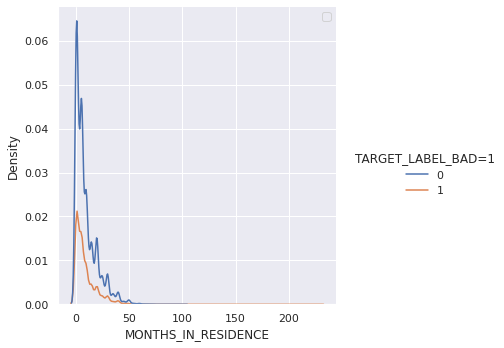

In [245]:
sns.set(color_codes=True)
sns.displot(data = cards_data, x = "MONTHS_IN_RESIDENCE", hue = "TARGET_LABEL_BAD=1",kind='kde')
plt.legend(loc='upper right')

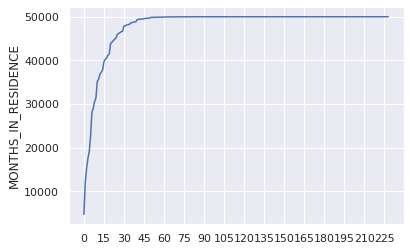

In [246]:
loc = plticker.MultipleLocator(base=15)
mnths_cumsum = cards_data['MONTHS_IN_RESIDENCE'].value_counts().sort_index().cumsum()
axes=sns.lineplot(x=mnths_cumsum.index,y=mnths_cumsum)
axes.xaxis.set_major_locator(loc)

No handles with labels found to put in legend.


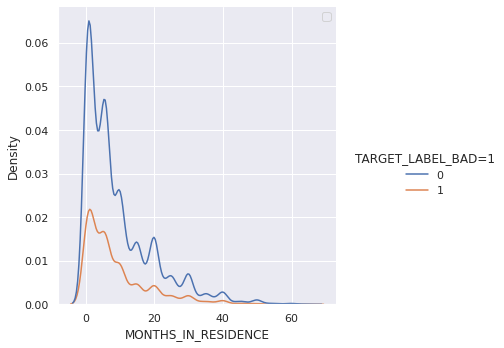

In [247]:
cards_data = cards_data.loc[(cards_data['MONTHS_IN_RESIDENCE'] <=65) | (cards_data['MONTHS_IN_RESIDENCE'].isnull())]
sns.displot(data = cards_data, x = "MONTHS_IN_RESIDENCE", hue = "TARGET_LABEL_BAD=1",kind='kde')
plt.legend(loc='upper right')


In [248]:
cards_data.shape

(49914, 34)

#### 2.7.3. PERSONAL MONTHLY INCOMES


No handles with labels found to put in legend.


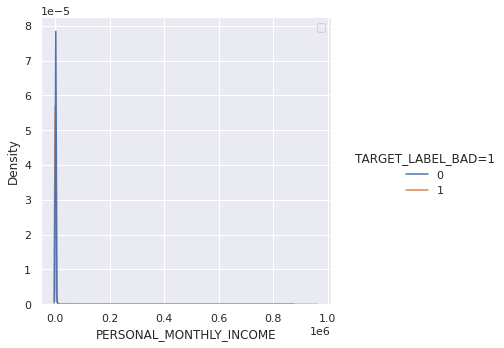

In [249]:
sns.set(color_codes=True)
sns.displot(data = cards_data, x = "PERSONAL_MONTHLY_INCOME", hue = "TARGET_LABEL_BAD=1",kind='kde')
plt.legend(loc='upper right')

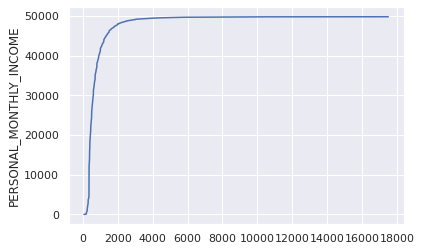

In [250]:
loc = plticker.MultipleLocator(base=2000)
mnths_cumsum = cards_data[cards_data['PERSONAL_MONTHLY_INCOME']<=20000]['PERSONAL_MONTHLY_INCOME'].value_counts().sort_index().cumsum()
axes=sns.lineplot(x=mnths_cumsum.index,y=mnths_cumsum)
axes.xaxis.set_major_locator(loc)

No handles with labels found to put in legend.


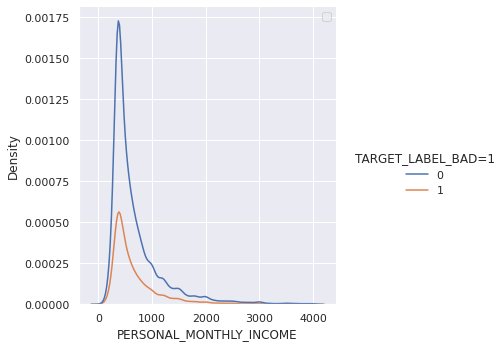

In [251]:
cards_data = cards_data.loc[(cards_data['PERSONAL_MONTHLY_INCOME'] <=4000) & (cards_data['PERSONAL_MONTHLY_INCOME'].notnull())]
sns.set(color_codes=True)
sns.displot(data = cards_data, x = "PERSONAL_MONTHLY_INCOME", hue = "TARGET_LABEL_BAD=1",kind='kde')
plt.legend(loc='upper right')


In [252]:
cards_data.shape

(49503, 34)

#### 2.7.4. OTHER INCOMES


No handles with labels found to put in legend.


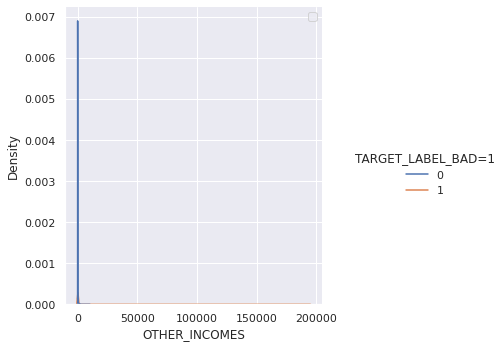

In [253]:
sns.set(color_codes=True)
sns.displot(data = cards_data, x = "OTHER_INCOMES", hue = "TARGET_LABEL_BAD=1",kind='kde')
plt.legend(loc='upper right')


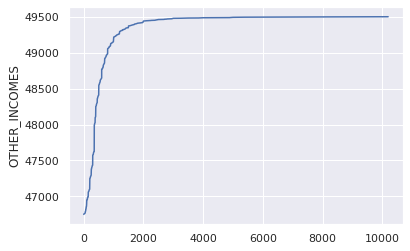

In [254]:
loc = plticker.MultipleLocator(base=2000)
mnths_cumsum = cards_data[cards_data['OTHER_INCOMES']<=20000]['OTHER_INCOMES'].value_counts().sort_index().cumsum()
axes=sns.lineplot(x=mnths_cumsum.index,y=mnths_cumsum)
axes.xaxis.set_major_locator(loc)


No handles with labels found to put in legend.


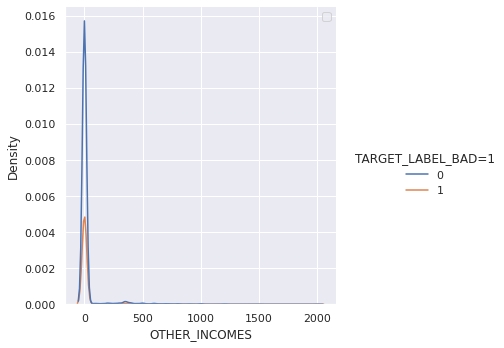

In [255]:
cards_data = cards_data.loc[(cards_data['OTHER_INCOMES'] <=2000) & (cards_data['OTHER_INCOMES'].notnull())]
sns.set(color_codes=True)
sns.displot(data = cards_data, x = "OTHER_INCOMES", hue = "TARGET_LABEL_BAD=1",kind='kde')
plt.legend(loc='upper right')


In [256]:
cards_data.shape

(49442, 34)

#### 2.7.5. PERSONAL ASSETS 

No handles with labels found to put in legend.


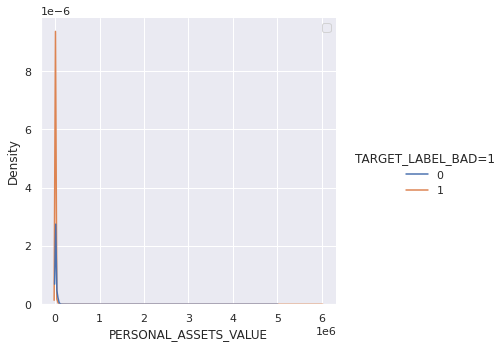

In [257]:
sns.set(color_codes=True)
sns.displot(data = cards_data, x = "PERSONAL_ASSETS_VALUE", hue = "TARGET_LABEL_BAD=1",kind='kde')
plt.legend(loc='upper right')

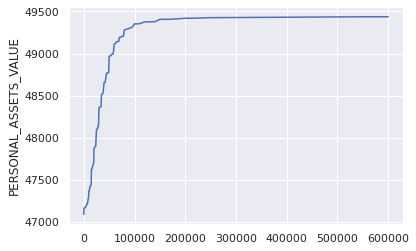

In [258]:
loc = plticker.MultipleLocator(base=100000)
mnths_cumsum = cards_data[cards_data['PERSONAL_ASSETS_VALUE']<=1000000]['PERSONAL_ASSETS_VALUE'].value_counts().sort_index().cumsum()
axes=sns.lineplot(x=mnths_cumsum.index,y=mnths_cumsum)
axes.xaxis.set_major_locator(loc)


No handles with labels found to put in legend.


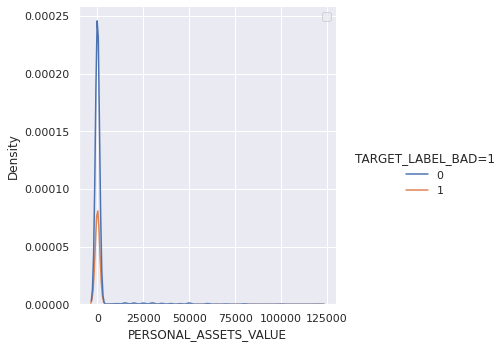

In [259]:
cards_data = cards_data.loc[(cards_data['PERSONAL_ASSETS_VALUE'] <=120000) & (cards_data['PERSONAL_ASSETS_VALUE'].notnull())]
sns.set(color_codes=True)
sns.displot(data = cards_data, x = "PERSONAL_ASSETS_VALUE", hue = "TARGET_LABEL_BAD=1",kind='kde')
plt.legend(loc='upper right')

#### 2.7.7. AGE

No handles with labels found to put in legend.


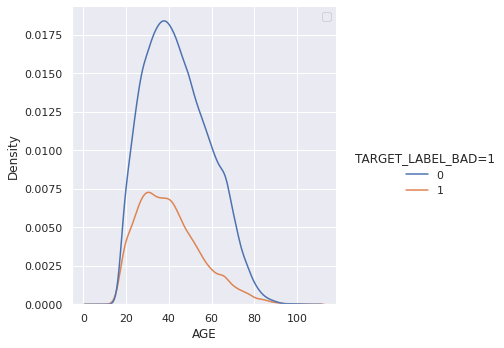

In [260]:
sns.set(color_codes=True)
sns.displot(data = cards_data, x = "AGE", hue = "TARGET_LABEL_BAD=1",kind='kde')
plt.legend(loc='upper right')


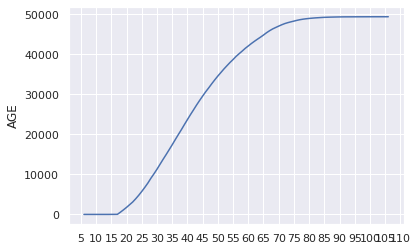

In [261]:

loc = plticker.MultipleLocator(base=5)
mnths_cumsum = cards_data['AGE'].value_counts().sort_index().cumsum()
axes=sns.lineplot(x=mnths_cumsum.index,y=mnths_cumsum)
axes.xaxis.set_major_locator(loc)

No handles with labels found to put in legend.


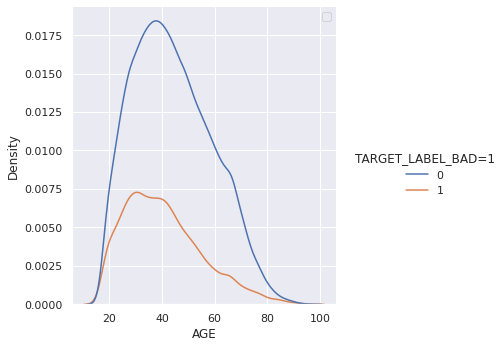

In [262]:
cards_data = cards_data.loc[(cards_data['AGE'] >=17) & (cards_data['AGE']<=95)]
sns.set(color_codes=True)
sns.displot(data = cards_data, x = "AGE", hue = "TARGET_LABEL_BAD=1",kind='kde')
plt.legend(loc='upper right')

In [263]:
cards_data.shape

(49356, 34)

## 2.8. STANDARDIZATION OF DATA


In [265]:
#testing values
import scorecardpy as sc
import numpy as np
from scipy.stats import zscore
train_PMI, test_PMI = sc.split_df(cards_data,y = 'TARGET_LABEL_BAD=1', ratio = 0.7,seed = 251238730).values()

In [164]:
numeric_cols = ['MONTHS_IN_RESIDENCE','PERSONAL_MONTHLY_INCOME','OTHER_INCOMES','PERSONAL_ASSETS_VALUE','income_per_familymember','AGE']
# Apply the zscore function to all data
cards_data[numeric_cols] = cards_data[numeric_cols].apply(zscore)

In [165]:
categorical_var = [i for i in cards_data.columns if i not in numeric_cols+['TARGET_LABEL_BAD=1']]

for i in categorical_var:
  if pd.api.types.is_numeric_dtype(cards_data[i]):
    cards_data[i]=cards_data[i].astype('str')


## 2.9. WEIGHT OF EVIDENCE


In [166]:
import scorecardpy as sc
import numpy as np

In [167]:
train_nwe, test_nwe = sc.split_df(cards_data,
                          y = 'TARGET_LABEL_BAD=1',
                          ratio = 0.7,
                          seed = 251238730).values()

In [168]:
train_nwe.to_csv('train_nwe.csv')
test_nwe.to_csv('test_nwe.csv')

In [169]:
bins = sc.woebin(train_nwe, y = 'TARGET_LABEL_BAD=1', 
                 min_perc_fine_bin=0.01, # How many bins to cut initially into
                 min_perc_coarse_bin=0.05,  # Minimum percentage per final bin
                 stop_limit=0.02, # Minimum information value 
                 max_num_bin=8, # Maximum number of bins
                 method='tree'
                 )


[INFO] creating woe binning ...
Binning on 34549 rows and 34 columns in 00:00:21


/usr/local/lib/python3.7/dist-packages/scorecardpy/woebin.py:1203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots()
/usr/local/lib/python3.7/dist-packages/scorecardpy/woebin.py:1203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots()
/usr/local/lib/python3.7/dist-packages/scorecardpy/woebin.py:1203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To co

{'AGE': <Figure size 432x288 with 2 Axes>,
 'APPLICATION_SUBMISSION_TYPE': <Figure size 432x288 with 2 Axes>,
 'COMPANY': <Figure size 432x288 with 2 Axes>,
 'FLAG_AMERICAN_EXPRESS': <Figure size 432x288 with 2 Axes>,
 'FLAG_DINERS': <Figure size 432x288 with 2 Axes>,
 'FLAG_EMAIL': <Figure size 432x288 with 2 Axes>,
 'FLAG_MASTERCARD': <Figure size 432x288 with 2 Axes>,
 'FLAG_OTHER_CARDS': <Figure size 432x288 with 2 Axes>,
 'FLAG_PROFESSIONAL_PHONE': <Figure size 432x288 with 2 Axes>,
 'FLAG_RESIDENCIAL_PHONE': <Figure size 432x288 with 2 Axes>,
 'FLAG_VISA': <Figure size 432x288 with 2 Axes>,
 'MARITAL_STATUS': <Figure size 432x288 with 2 Axes>,
 'MONTHS_IN_RESIDENCE': <Figure size 432x288 with 2 Axes>,
 'NACIONALITY': <Figure size 432x288 with 2 Axes>,
 'OCCUPATION_TYPE': <Figure size 432x288 with 2 Axes>,
 'OTHER_INCOMES': <Figure size 432x288 with 2 Axes>,
 'PAYMENT_DAY': <Figure size 432x288 with 2 Axes>,
 'PERSONAL_ASSETS_VALUE': <Figure size 432x288 with 2 Axes>,
 'PERSONAL_M

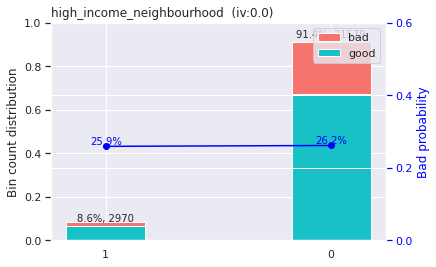

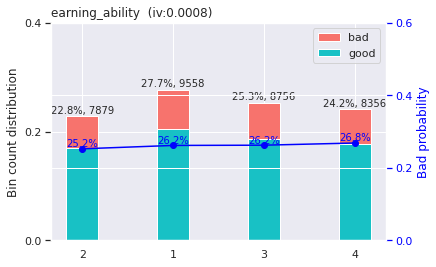

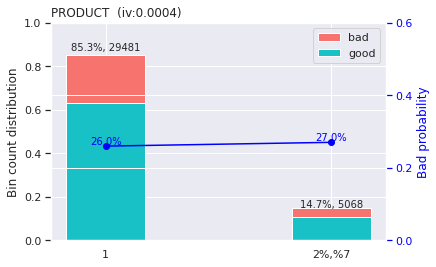

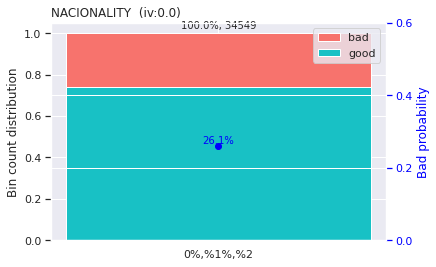

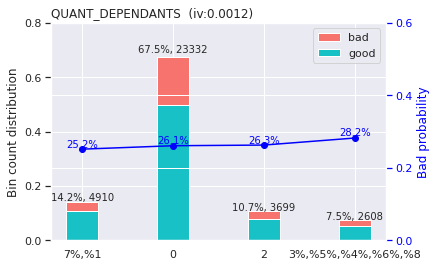

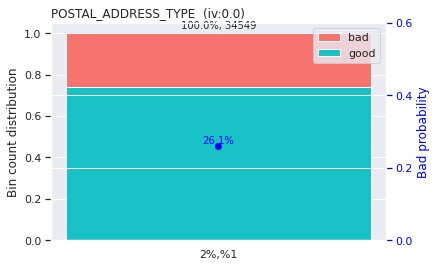

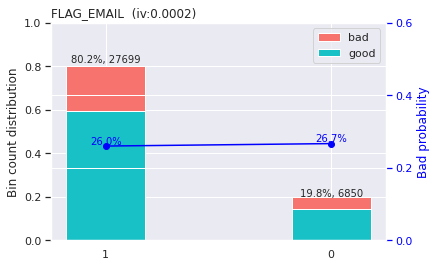

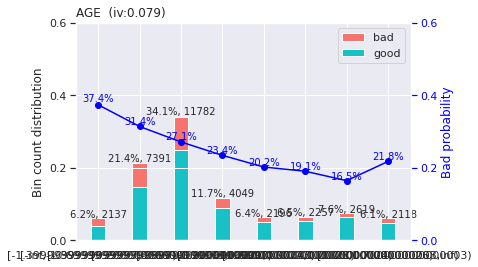

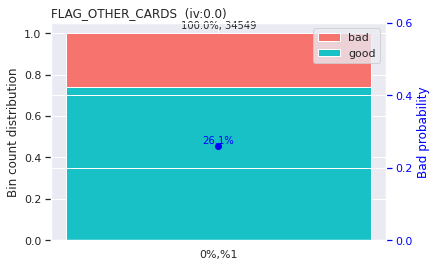

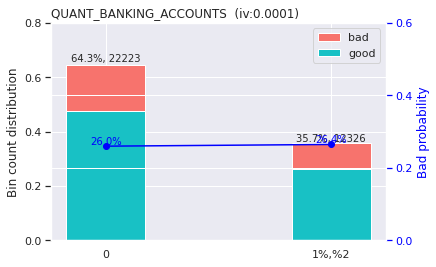

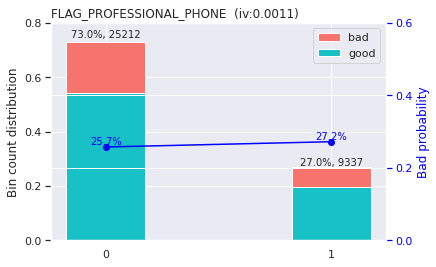

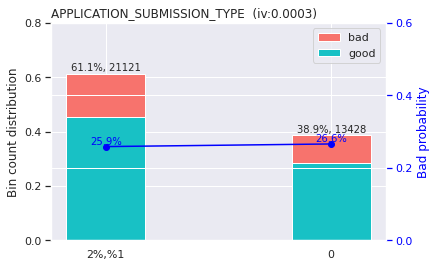

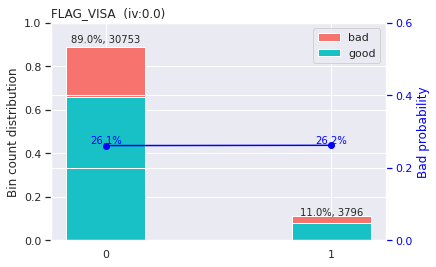

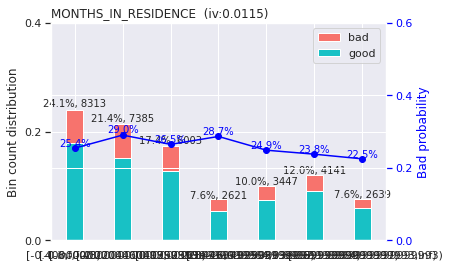

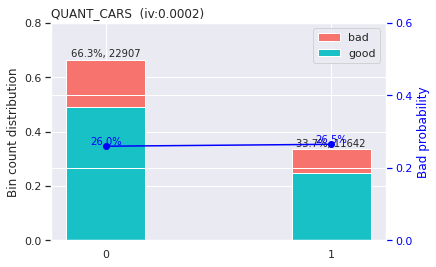

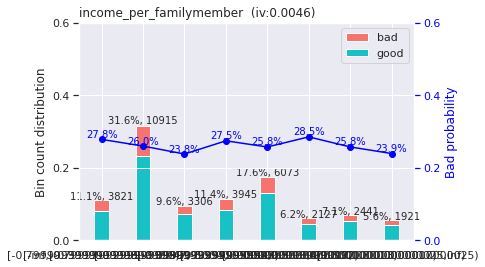

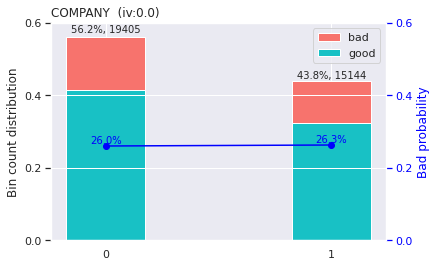

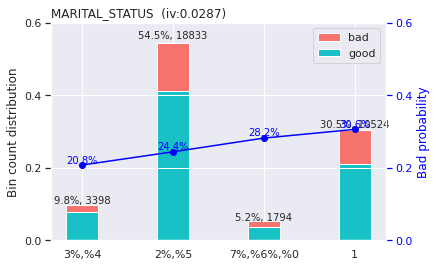

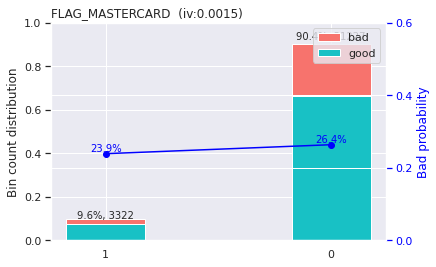

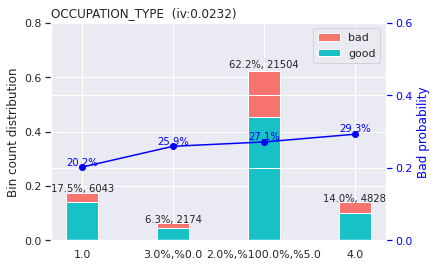

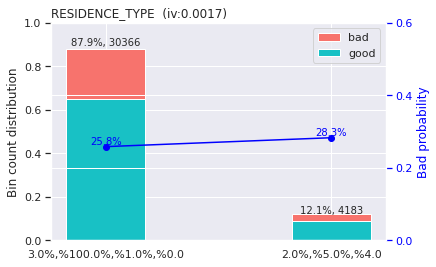

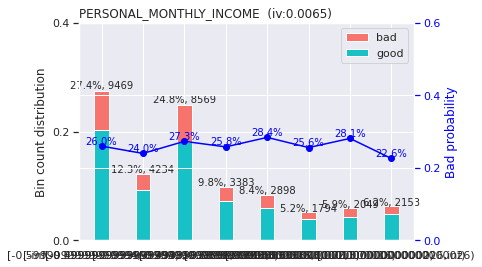

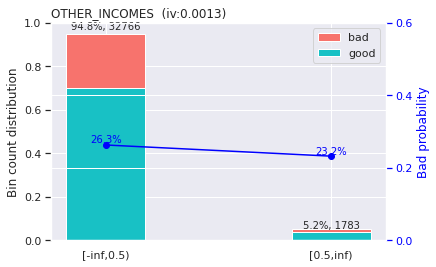

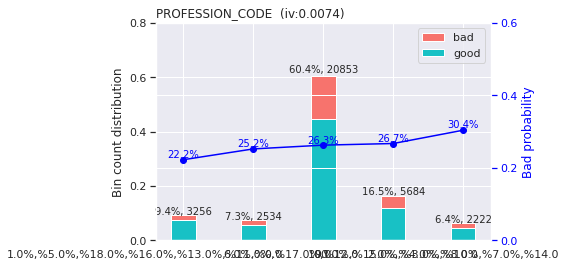

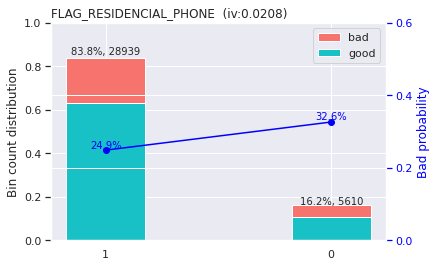

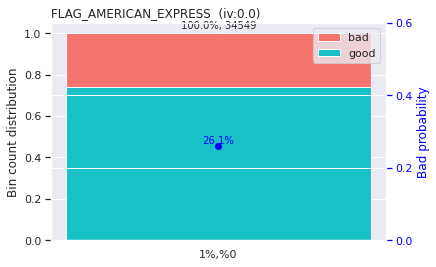

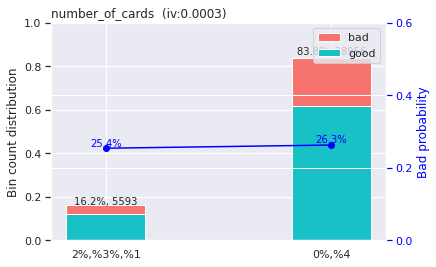

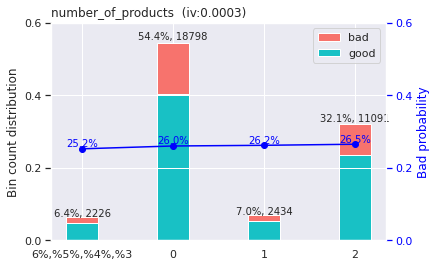

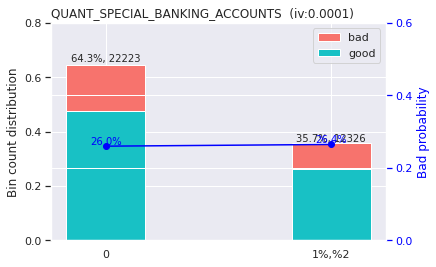

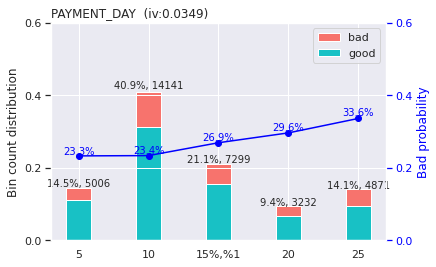

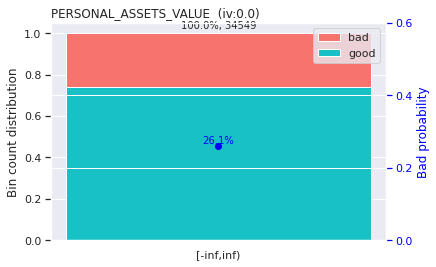

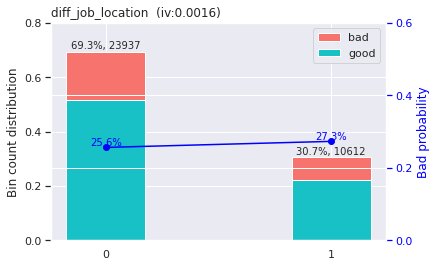

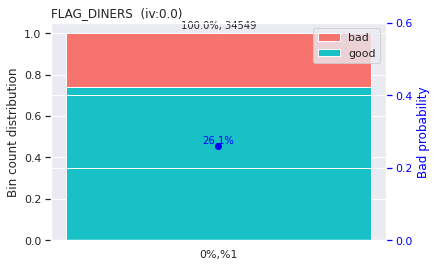

In [170]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sc.woebin_plot(bins)

-------- 1/13 AGE --------
>>> dt[AGE].describe(): 
count    34549.000000
mean         0.006175
std          0.999803
min         -1.749592
25%         -0.812057
50%         -0.142389
75%          0.661212
max          3.473817
Name: AGE, dtype: float64 



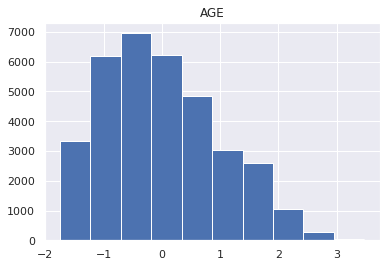

>>> Current breaks:
-1.3999999999999997,-0.6999999999999991,0.20000000000000173,0.6000000000000021,0.9000000000000024,1.2000000000000026,1.700000000000003 



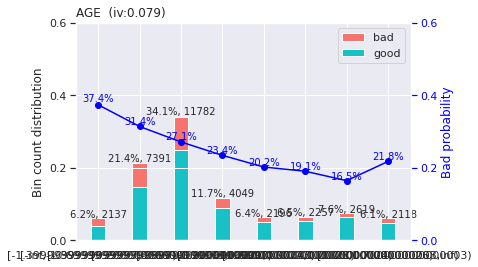

>>> Adjust breaks for (1/13) AGE?
1: next 
2: yes 
3: back
Selection: 1
-------- 2/13 FLAG_PROFESSIONAL_PHONE --------
>>> dt[FLAG_PROFESSIONAL_PHONE].describe(): 
count     34549
unique        2
top           0
freq      25212
Name: FLAG_PROFESSIONAL_PHONE, dtype: object 

>>> dt[FLAG_PROFESSIONAL_PHONE].value_counts(): 
0    25212
1     9337
Name: FLAG_PROFESSIONAL_PHONE, dtype: int64 

>>> Current breaks:
'0','1' 



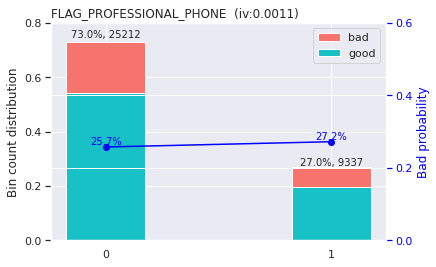

>>> Adjust breaks for (2/13) FLAG_PROFESSIONAL_PHONE?
1: next 
2: yes 
3: back
Selection: 1
-------- 3/13 MARITAL_STATUS --------
>>> dt[MARITAL_STATUS].describe(): 
count     34549
unique        8
top           2
freq      17947
Name: MARITAL_STATUS, dtype: object 

>>> dt[MARITAL_STATUS].value_counts(): 
2    17947
1    10524
4     2962
6     1294
5      886
3      436
7      363
0      137
Name: MARITAL_STATUS, dtype: int64 

>>> Current breaks:
'3%,%4','2%,%5','7%,%6%,%0','1' 



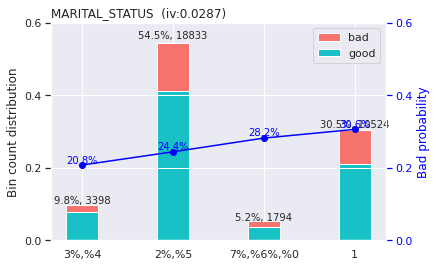

>>> Adjust breaks for (3/13) MARITAL_STATUS?
1: next 
2: yes 
3: back
Selection: 1
-------- 4/13 MONTHS_IN_RESIDENCE --------
>>> dt[MONTHS_IN_RESIDENCE].describe(): 
count    34549.000000
mean         0.003169
std          1.003919
min         -0.932699
25%         -0.733598
50%         -0.335394
75%          0.461013
max          5.538107
Name: MONTHS_IN_RESIDENCE, dtype: float64 



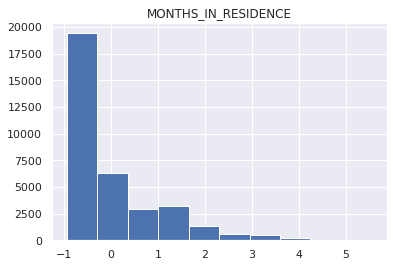

>>> Current breaks:
-0.8,-0.40000000000000013,-2.220446049250313e-16,0.09999999999999964,0.6999999999999997,1.6999999999999993 



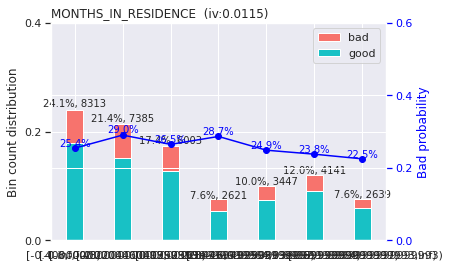

>>> Adjust breaks for (4/13) MONTHS_IN_RESIDENCE?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: 0.6999999999999997, 1.6999999999999993, 0.09999999999999964, -0.8
[INFO] creating woe binning ...
>>> Current breaks:
-0.8, 1.6999999999999993, 0.6999999999999997, 0.09999999999999964 



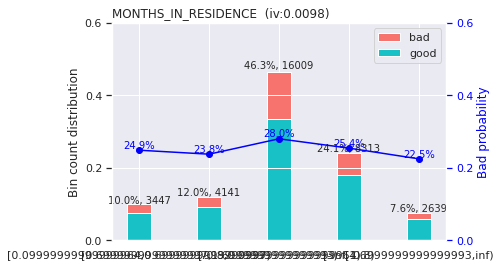

>>> Adjust breaks for (4/13) MONTHS_IN_RESIDENCE?
1: next 
2: yes 
3: back
Selection: 3
-------- 3/13 MARITAL_STATUS --------
>>> dt[MARITAL_STATUS].describe(): 
count     34549
unique        8
top           2
freq      17947
Name: MARITAL_STATUS, dtype: object 

>>> dt[MARITAL_STATUS].value_counts(): 
2    17947
1    10524
4     2962
6     1294
5      886
3      436
7      363
0      137
Name: MARITAL_STATUS, dtype: int64 

>>> Current breaks:
'3%,%4','2%,%5','7%,%6%,%0','1' 



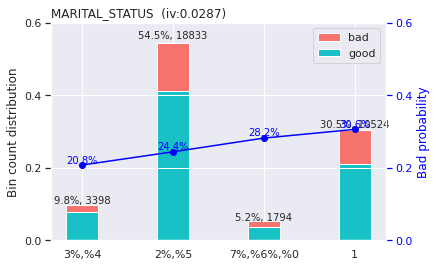

>>> Adjust breaks for (3/13) MARITAL_STATUS?
1: next 
2: yes 
3: back
Selection: 1
-------- 4/13 MONTHS_IN_RESIDENCE --------
>>> dt[MONTHS_IN_RESIDENCE].describe(): 
count    34549.000000
mean         0.003169
std          1.003919
min         -0.932699
25%         -0.733598
50%         -0.335394
75%          0.461013
max          5.538107
Name: MONTHS_IN_RESIDENCE, dtype: float64 



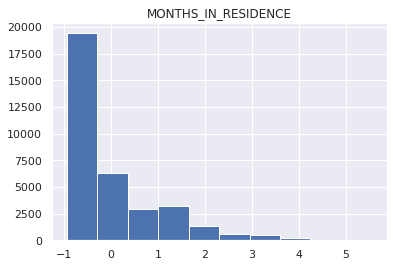

>>> Current breaks:
-0.8,-0.40000000000000013,-2.220446049250313e-16,0.09999999999999964,0.6999999999999997,1.6999999999999993 



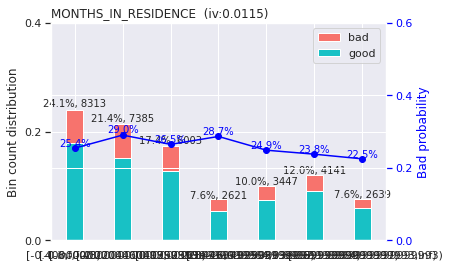

>>> Adjust breaks for (4/13) MONTHS_IN_RESIDENCE?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks:  -0.8, 0.09999999999999964, 0.6999999999999997, 1.6999999999999993
[INFO] creating woe binning ...
>>> Current breaks:
-0.8, 1.6999999999999993, 0.6999999999999997, 0.09999999999999964 



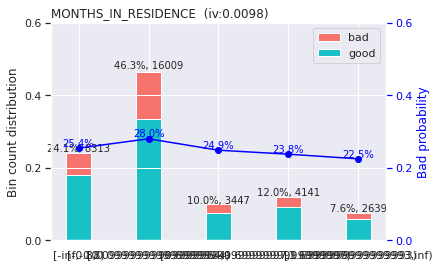

>>> Adjust breaks for (4/13) MONTHS_IN_RESIDENCE?
1: next 
2: yes 
3: back
Selection: 1
-------- 5/13 OCCUPATION_TYPE --------
>>> dt[OCCUPATION_TYPE].describe(): 
count     34549
unique        7
top         2.0
freq      11663
Name: OCCUPATION_TYPE, dtype: object 

>>> dt[OCCUPATION_TYPE].value_counts(): 
2.0      11663
1.0       6043
100.0     5043
4.0       4828
5.0       4798
0.0       1957
3.0        217
Name: OCCUPATION_TYPE, dtype: int64 

>>> Current breaks:
'1.0','3.0%,%0.0','2.0%,%100.0%,%5.0','4.0' 



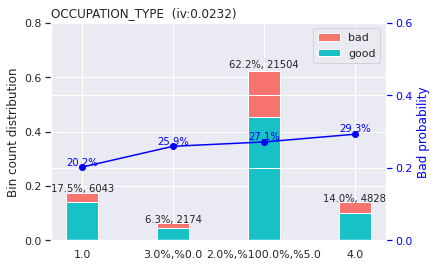

>>> Adjust breaks for (5/13) OCCUPATION_TYPE?
1: next 
2: yes 
3: back
Selection: 1
-------- 6/13 PAYMENT_DAY --------
>>> dt[PAYMENT_DAY].describe(): 
count     34549
unique        6
top          10
freq      14141
Name: PAYMENT_DAY, dtype: object 

>>> dt[PAYMENT_DAY].value_counts(): 
10    14141
15     6101
5      5006
25     4871
20     3232
1      1198
Name: PAYMENT_DAY, dtype: int64 

>>> Current breaks:
'5','10','15%,%1','20','25' 



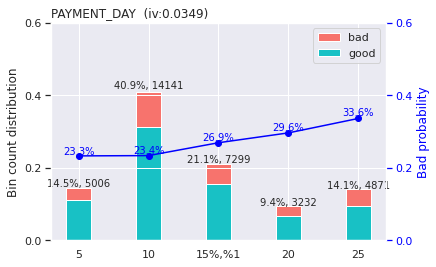

>>> Adjust breaks for (6/13) PAYMENT_DAY?
1: next 
2: yes 
3: back
Selection: 1
-------- 7/13 PERSONAL_MONTHLY_INCOME --------
>>> dt[PERSONAL_MONTHLY_INCOME].describe(): 
count    34549.000000
mean         0.000267
std          0.998484
min         -1.226550
25%         -0.628946
50%         -0.350064
75%          0.247540
max          6.621980
Name: PERSONAL_MONTHLY_INCOME, dtype: float64 



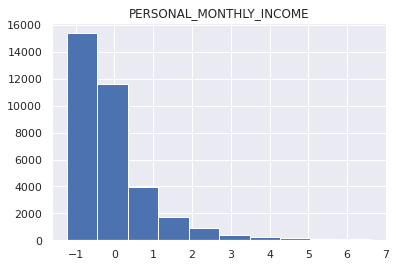

>>> Current breaks:
-0.5999999999999994,-0.49999999999999933,-0.09999999999999898,0.2000000000000013,0.6000000000000016,1.000000000000002,1.7000000000000026 



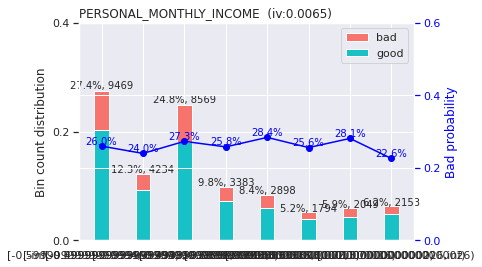

>>> Adjust breaks for (7/13) PERSONAL_MONTHLY_INCOME?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: -0.09999999999999898, 0.2000000000000013, 1.000000000000002, 1.7000000000000026
[INFO] creating woe binning ...
>>> Current breaks:
1.000000000000002, 1.7000000000000026, -0.09999999999999898, 0.2000000000000013 



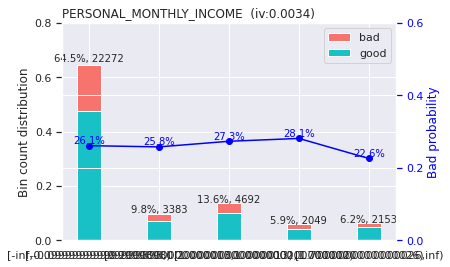

>>> Adjust breaks for (7/13) PERSONAL_MONTHLY_INCOME?
1: next 
2: yes 
3: back
Selection: 1
-------- 8/13 PROFESSION_CODE --------
>>> dt[PROFESSION_CODE].describe(): 
count     34549
unique       20
top         9.0
freq      20853
Name: PROFESSION_CODE, dtype: object 

>>> dt[PROFESSION_CODE].value_counts(): 
9.0      20853
100.0     5335
0.0       2452
11.0      2431
2.0       1965
12.0       338
10.0       294
16.0       232
13.0       218
7.0        149
8.0         85
6.0         82
15.0        44
17.0        26
4.0         19
3.0         11
5.0          6
14.0         4
1.0          4
18.0         1
Name: PROFESSION_CODE, dtype: int64 

>>> Current breaks:
'1.0%,%5.0%,%18.0%,%16.0%,%13.0%,%11.0%,%17.0%,%12.0','6.0%,%0.0','9.0','100.0%,%15.0%,%3.0%,%10.0','2.0%,%4.0%,%8.0%,%7.0%,%14.0' 



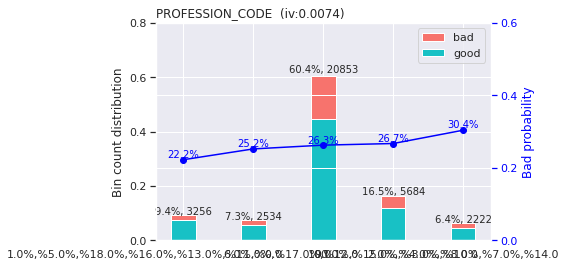

>>> Adjust breaks for (8/13) PROFESSION_CODE?
1: next 
2: yes 
3: back
Selection: 1
-------- 9/13 QUANT_DEPENDANTS --------
>>> dt[QUANT_DEPENDANTS].describe(): 
count     34549
unique        9
top           0
freq      23332
Name: QUANT_DEPENDANTS, dtype: object 

>>> dt[QUANT_DEPENDANTS].value_counts(): 
0    23332
1     4867
2     3699
3     1644
4      576
5      261
6      100
7       43
8       27
Name: QUANT_DEPENDANTS, dtype: int64 

>>> Current breaks:
'7%,%1','0','2','3%,%5%,%4%,%6%,%8' 



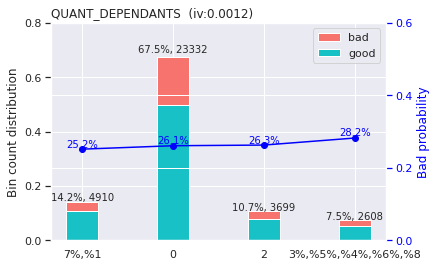

>>> Adjust breaks for (9/13) QUANT_DEPENDANTS?
1: next 
2: yes 
3: back
Selection: 1
-------- 10/13 QUANT_SPECIAL_BANKING_ACCOUNTS --------
>>> dt[QUANT_SPECIAL_BANKING_ACCOUNTS].describe(): 
count     34549
unique        3
top           0
freq      22223
Name: QUANT_SPECIAL_BANKING_ACCOUNTS, dtype: object 

>>> dt[QUANT_SPECIAL_BANKING_ACCOUNTS].value_counts(): 
0    22223
1    12318
2        8
Name: QUANT_SPECIAL_BANKING_ACCOUNTS, dtype: int64 

>>> Current breaks:
'0','1%,%2' 



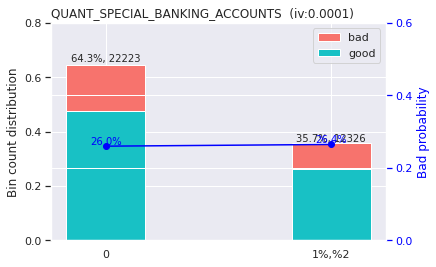

>>> Adjust breaks for (10/13) QUANT_SPECIAL_BANKING_ACCOUNTS?
1: next 
2: yes 
3: back
Selection: 1
-------- 11/13 earning_ability --------
>>> dt[earning_ability].describe(): 
count     34549
unique        4
top           1
freq       9558
Name: earning_ability, dtype: object 

>>> dt[earning_ability].value_counts(): 
1    9558
3    8756
4    8356
2    7879
Name: earning_ability, dtype: int64 

>>> Current breaks:
'2','1','3','4' 



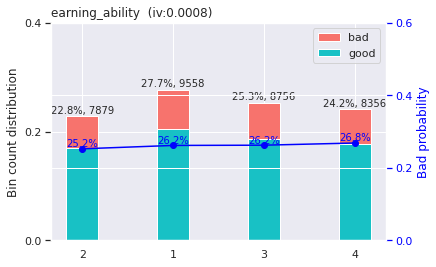

>>> Adjust breaks for (11/13) earning_ability?
1: next 
2: yes 
3: back
Selection: 1
-------- 12/13 income_per_familymember --------
>>> dt[income_per_familymember].describe(): 
count    34549.000000
mean         0.001719
std          0.998970
min         -1.116391
25%         -0.553828
50%         -0.318292
75%          0.226056
max          9.027437
Name: income_per_familymember, dtype: float64 



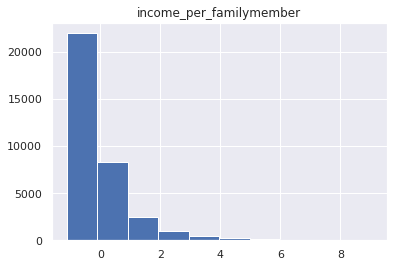

>>> Current breaks:
-0.7999999999999998,-0.39999999999999947,-0.2999999999999994,-0.0999999999999992,0.5000000000000013,0.9000000000000017,1.8000000000000025 



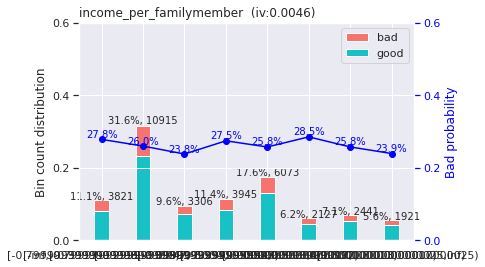

>>> Adjust breaks for (12/13) income_per_familymember?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: -0.0999999999999992, -0.7999999999999998, 0.5000000000000013, 0.9000000000000017, 1.8000000000000025
[INFO] creating woe binning ...
>>> Current breaks:
0.5000000000000013, -0.0999999999999992, 0.9000000000000017, 1.8000000000000025, -0.7999999999999998 



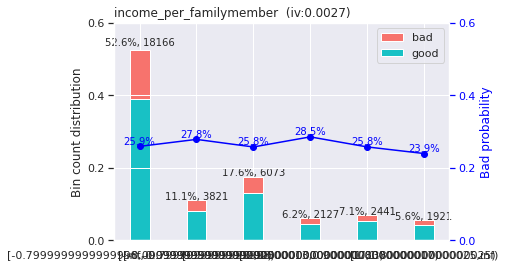

>>> Adjust breaks for (12/13) income_per_familymember?
1: next 
2: yes 
3: back
Selection: 1
-------- 13/13 number_of_products --------
>>> dt[number_of_products].describe(): 
count     34549
unique        7
top           0
freq      18798
Name: number_of_products, dtype: object 

>>> dt[number_of_products].value_counts(): 
0    18798
2    11091
1     2434
3     1586
4      618
5       17
6        5
Name: number_of_products, dtype: int64 

>>> Current breaks:
'6%,%5%,%4%,%3','0','1','2' 



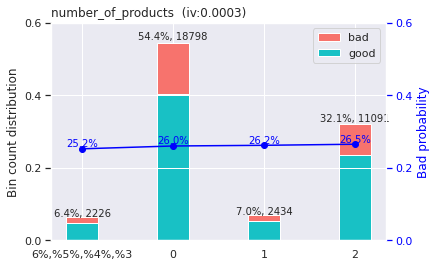

>>> Adjust breaks for (13/13) number_of_products?
1: next 
2: yes 
3: back
Selection: 1


In [172]:
breaks_adj = sc.woebin_adj(train_nwe, "TARGET_LABEL_BAD=1", bins, adj_all_var = False)

In [173]:
bins_adj = sc.woebin(train_nwe, y="TARGET_LABEL_BAD=1", breaks_list=breaks_adj) # Apply new cuts
train_woe = sc.woebin_ply(train_nwe, bins_adj) # Calculate WoE dataset (train)
test_woe = sc.woebin_ply(test_nwe, bins_adj)

[INFO] creating woe binning ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [174]:
iv_df = sc.iv(train_woe, 'TARGET_LABEL_BAD=1')

In [175]:
iv_df

,variable,info_value
2,AGE_woe,0.079046
16,PAYMENT_DAY_woe,0.034917
18,MARITAL_STATUS_woe,0.028701
13,OCCUPATION_TYPE_woe,0.023160
20,FLAG_RESIDENCIAL_PHONE_woe,0.020771
24,MONTHS_IN_RESIDENCE_woe,0.009796
12,PROFESSION_CODE_woe,0.007353
4,PERSONAL_MONTHLY_INCOME_woe,0.003375
26,income_per_familymember_woe,0.002676
30,RESIDENCE_TYPE_woe,0.001691


In [176]:
final_training_variables = iv_df.iloc[[0,1,2,3,4,6,7,8,9,11,12,13,15],:].loc[:,'variable']
final_training_variables

2                         AGE_woe
16                PAYMENT_DAY_woe
18             MARITAL_STATUS_woe
13            OCCUPATION_TYPE_woe
20     FLAG_RESIDENCIAL_PHONE_woe
12            PROFESSION_CODE_woe
4     PERSONAL_MONTHLY_INCOME_woe
26    income_per_familymember_woe
30             RESIDENCE_TYPE_woe
28            FLAG_MASTERCARD_woe
25              OTHER_INCOMES_woe
5            QUANT_DEPENDANTS_woe
3             earning_ability_woe
Name: variable, dtype: object

In [177]:
train_final = train_woe[['TARGET_LABEL_BAD=1']+list(final_training_variables)]
test_final = test_woe[['TARGET_LABEL_BAD=1']+list(final_training_variables)]

## 2.10. CORRELATION ANALYSIS


In [178]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

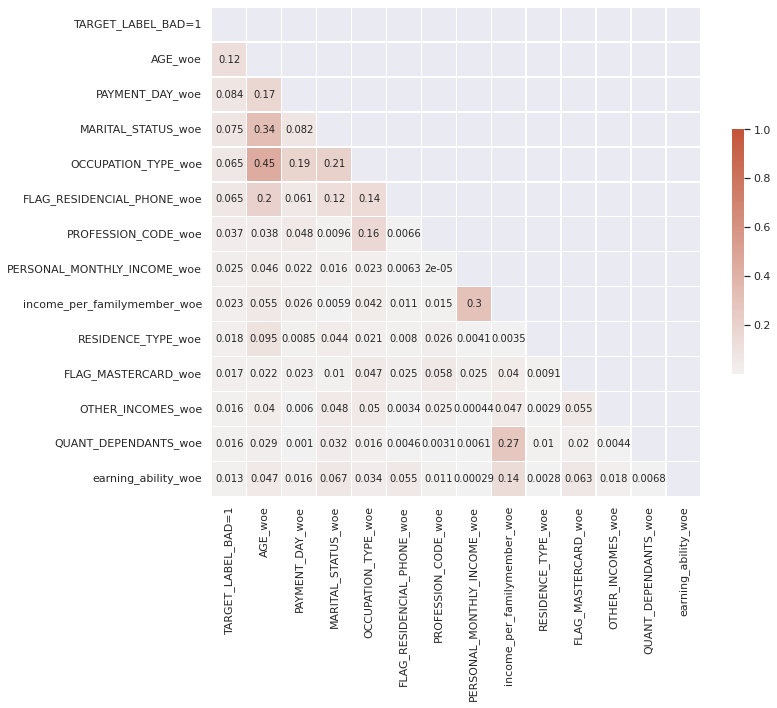

In [179]:
# Compute the correlation matrix
corr = train_final.corr()
corr = np.abs(corr)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

## 2.10. LOGISTIC REGRESSION TRAINING


In [180]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,auc,ConfusionMatrixDisplay


In [181]:
cards_logReg = LogisticRegressionCV(penalty='elasticnet', # Type of penalization l1 = lasso, l2 = ridge, elasticnet
                                     Cs = 10,        # How many parameters to try. Can also be a vector with parameters to try.
                                     tol=0.000001, # Tolerance for parameters
                                     cv = 3,     # How many CV folds to try. 3 or 5 should be enough.
                                     fit_intercept=True, # Use constant?
                                     class_weight='balanced', # Weights, see below
                                     random_state=251238730, # Random seed
                                     max_iter=50, # Maximum iterations
                                     verbose=2, # Show process. 1 is yes.
                                     solver = 'saga', # How to optimize.
                                     n_jobs = 2,      # Processes to use. Set to number of physical cores. 
                                     refit = True,     # If to retrain with the best parameter and all data after finishing.
                                     l1_ratios = np.arange(0, 1.01, 0.1), # The LASSO / Ridge ratios.
                                    )

In [182]:
train_final_X = train_final.drop(['TARGET_LABEL_BAD=1'],axis=1)
train_final_y = train_final['TARGET_LABEL_BAD=1']
test_final_X = test_final.drop(['TARGET_LABEL_BAD=1'],axis=1)
test_final_y = test_final['TARGET_LABEL_BAD=1']


In [ ]:
lr = cards_logReg.fit(train_final_X,train_final_y)

In [185]:
import pickle
# save the classifier
with open('Cards_logReg.pkl', 'wb') as fid:
    pickle.dump(cards_logReg, fid) 

In [186]:
cards_logReg.coef_

array([[0.98977549, 0.79382367, 0.59692425, 0.09931159, 1.68447278,
        0.81563694, 0.54352743, 0.31390607, 0.24744507, 1.08988148,
        0.32610161, 1.04457682, 1.76440664]])

In [187]:
coef_df = pd.concat([pd.DataFrame({'column': train_final_X.columns}), 
                    pd.DataFrame(np.transpose(cards_logReg.coef_))],
                    axis = 1
                   )

coef_df

,column,0
0,AGE_woe,0.989775
1,PAYMENT_DAY_woe,0.793824
2,MARITAL_STATUS_woe,0.596924
3,OCCUPATION_TYPE_woe,0.099312
4,FLAG_RESIDENCIAL_PHONE_woe,1.684473
5,PROFESSION_CODE_woe,0.815637
6,PERSONAL_MONTHLY_INCOME_woe,0.543527
7,income_per_familymember_woe,0.313906
8,RESIDENCE_TYPE_woe,0.247445
9,FLAG_MASTERCARD_woe,1.089881


In [188]:
cards_logReg.intercept_

array([-0.00112434])

In [189]:
print(cards_logReg.l1_ratio_)
print(cards_logReg.C_)

[0.9]
[0.35938137]


In [190]:
fpr, tpr, thresholds = roc_curve(test_final_y,cards_logReg.predict_proba(test_final_X)[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

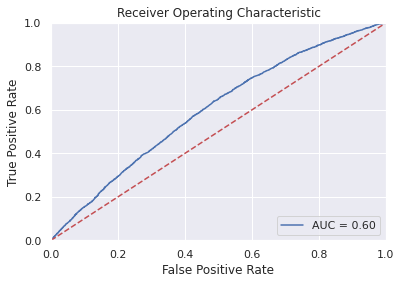

In [191]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [192]:
#Preds at threshold
preds_th = [1 if i>=0.5 else 0 for i in cards_logReg.predict_proba(test_final_X)[:,1]]

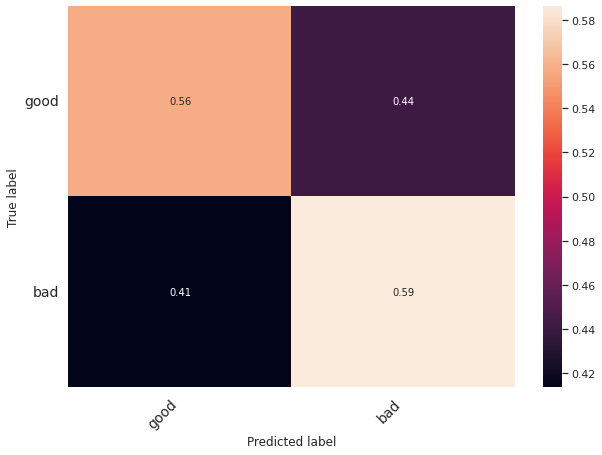

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Calculate confusion matrix
confusion_matrix_rf = confusion_matrix(y_true = test_final_y, 
                    y_pred = preds_th)

# Turn matrix to percentages
confusion_matrix_rf = confusion_matrix_rf.astype('float') / confusion_matrix_rf.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_rf, index=['good', 'bad'], columns=['good', 'bad'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

## 2.11. SCORECARD CREATION


In [194]:
creditcard_sc = sc.scorecard(bins_adj,         # bins from the WoE
                           cards_logReg,  # Trained logistic regression
                           train_final_X.columns, # The column names in the trained LR
                           points0=750, # Base points
                           odds0=0.01, # Base odds bads:goods
                           pdo=50
                           ) # PDO 

In [195]:
creditcard_sc

{'AGE':    variable                                        bin  points
 16      AGE                 [-inf,-1.3999999999999997)   -37.0
 17      AGE  [-1.3999999999999997,-0.6999999999999991)   -18.0
 18      AGE  [-0.6999999999999991,0.20000000000000173)    -4.0
 19      AGE   [0.20000000000000173,0.6000000000000021)    10.0
 20      AGE    [0.6000000000000021,0.9000000000000024)    24.0
 21      AGE    [0.9000000000000024,1.2000000000000026)    29.0
 22      AGE     [1.2000000000000026,1.700000000000003)    42.0
 23      AGE                    [1.700000000000003,inf)    17.0,
 'FLAG_MASTERCARD':            variable bin  points
 52  FLAG_MASTERCARD   1     9.0
 53  FLAG_MASTERCARD   0    -1.0,
 'FLAG_RESIDENCIAL_PHONE':                   variable bin  points
 72  FLAG_RESIDENCIAL_PHONE   1     8.0
 73  FLAG_RESIDENCIAL_PHONE   0   -38.0,
 'MARITAL_STATUS':           variable        bin  points
 48  MARITAL_STATUS      3%,%4    13.0
 49  MARITAL_STATUS      2%,%5     4.0
 50  MARITAL_ST

In [196]:
train_score = sc.scorecard_ply(train_nwe, creditcard_sc, 
                               print_step=0)
test_score = sc.scorecard_ply(test_nwe, creditcard_sc, 
                               print_step=0)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [197]:
train_score.describe()

,score
count,34549.000000
mean,421.115893
std,30.776352
min,311.000000
25%,400.000000
50%,420.000000
75%,441.000000
max,514.000000


## 2.12. SCORECARD CREATION USING RF AND XGB


#### 2.12.1. Random Forests Classifier

In [292]:
from sklearn.ensemble import RandomForestClassifier

#Define the classifier
Cards_RF = RandomForestClassifier(n_estimators=1000, # Number of trees to train
                       criterion='entropy', # How to train the trees. Also supports gini.
                       max_depth=None, # Max depth of the trees. Not necessary to change.
                       min_samples_split=2, # Minimum samples to create a split.
                       min_samples_leaf=0.0001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features='auto', # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.00001, # Minimum impurity decrease. This is 10^-4.
                       bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=True,  # If report accuracy with non-selected cases.
                       n_jobs=2, # Parallel processing. Set to the number of cores you have. Watch your RAM!!
                       random_state=251238730, # Seed
                       verbose=1, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                       class_weight='balanced' # Balance the classes.
                                    )

In [293]:
# Train the RF.
Cards_RF.fit(train_nwe.drop(['TARGET_LABEL_BAD=1'],axis=1), # X 
             train_nwe['TARGET_LABEL_BAD=1']    # y
                )  

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    6.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   14.6s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:   26.1s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:   32.8s finished
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       min_impurity_decrease=1e-05, min_samples_leaf=0.0001,
                       n_estimators=1000, n_jobs=2, oob_score=True,
                       random_state=251238730, verbose=1)

In [294]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve,auc

# Apply the model to the test set.
rf_pred_class_test = Cards_RF.predict(test_nwe.drop(['TARGET_LABEL_BAD=1'],axis=1))
rf_probs_test = Cards_RF.predict_proba(test_nwe.drop(['TARGET_LABEL_BAD=1'],axis=1))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    2.0s finished


In [295]:
preds_th_rf = [1 if i>=0.42 else 0 for i in rf_probs_test[:,1]]

In [296]:
fpr, tpr, thresholds = roc_curve(test_nwe['TARGET_LABEL_BAD=1'],rf_probs_test[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

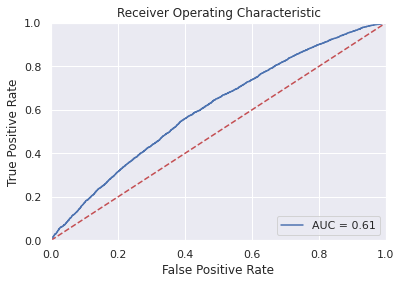

In [297]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


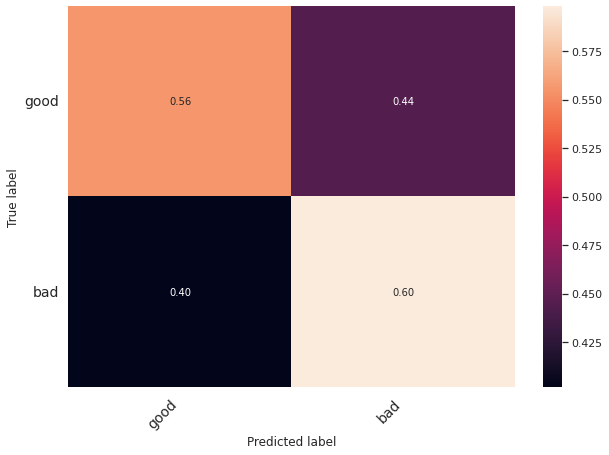

In [298]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Calculate confusion matrix
confusion_matrix_rf = confusion_matrix(y_true = test_nwe['TARGET_LABEL_BAD=1'], 
                    y_pred = preds_th_rf)

# Turn matrix to percentages
confusion_matrix_rf = confusion_matrix_rf.astype('float') / confusion_matrix_rf.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_rf, index=['good', 'bad'], columns=['good', 'bad'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

#### 2.12.2. XG Boost Classifier

In [299]:
cards_data_XGB = cards_data

In [300]:
for i in cards_data_XGB.columns:
  cards_data_XGB[i] = cards_data_XGB[i].astype(float)

In [301]:
train_nwe, test_nwe = sc.split_df(cards_data_XGB,
                          y = 'TARGET_LABEL_BAD=1',
                          ratio = 0.7,
                          seed = 251238730).values()

In [302]:
from xgboost import XGBClassifier 
#Define the classifier.
XGB_Credit = XGBClassifier(max_depth=4,                 # Depth of each tree
                            learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=50,             # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='binary:logistic',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=2,                    # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=0.632,              # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=1,           # Balancing of positive and negative weights. G / B
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=251238730,        # Seed
                            missing=None,                 # How are nulls encoded?
                            tree_method='hist',       # How to train the trees?
                            #gpu_id=0                      # With which GPU? 
                            )

In [303]:
# Define the parameters. Play with this grid!
param_grid = dict({'n_estimators': [50, 100, 150],
                   'max_depth': [2, 3, 4],
                 'learning_rate' : [0.01, 0.05, 0.1, 0.15]
                  })

In [304]:
val_train = train_nwe.sample(frac = 0.5,               # The fraction to extract
                                       random_state = 251238730,    # The seed.
                                       )

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define grid search object.
GridXGB = GridSearchCV(XGB_Credit,        # Original XGB. 
                       param_grid,          # Parameter grid
                       cv = 3,              # Number of cross-validation folds.  
                       scoring = 'roc_auc', # How to rank outputs.
                       n_jobs = 2,          # Parallel jobs. -1 is "all you have"
                       refit = False,       # If refit at the end with the best. We'll do it manually.
                       verbose = 1          # If to show what it is doing.
                      )

In [ ]:
# Train grid search.
GridXGB.fit(val_train.drop(['TARGET_LABEL_BAD=1'],axis=1), val_train['TARGET_LABEL_BAD=1'])

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(gamma=0.001, max_depth=2, n_estimators=50,
                                     n_jobs=2, random_state=251238730,
                                     reg_alpha=1, reg_lambda=0, subsample=0.632,
                                     tree_method='hist'),
             n_jobs=2,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [50, 100, 150]},
             refit=False, scoring='roc_auc', verbose=1)

In [ ]:
# Show best params
print('The best AUC is %.3f' % GridXGB.best_score_)
GridXGB.best_params_

The best AUC is 0.616


{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 150}

In [ ]:
# Create XGB with best parameters.
XGB_creditcard = XGBClassifier(max_depth=GridXGB.best_params_.get('max_depth'), # Depth of each tree
                            learning_rate=GridXGB.best_params_.get('learning_rate'), # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=GridXGB.best_params_.get('n_estimators'), # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='binary:logistic',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            #n_jobs=4,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=0.632,              # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=1,           # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=251238730,        # Seed
                            missing=None                 # How are nulls encoded?
                            # tree_method='gpu_exact',       # How to train the trees?
                            # gpu_id=0                     # With which GPU?
                            )

In [306]:
# Train over all training data.
XGB_creditcard.fit(train_nwe.drop(['TARGET_LABEL_BAD=1'],axis=1), train_nwe['TARGET_LABEL_BAD=1'])

XGBClassifier(gamma=0.001, max_depth=2, n_estimators=150,
              random_state=251238730, reg_alpha=1, reg_lambda=0,
              subsample=0.632)

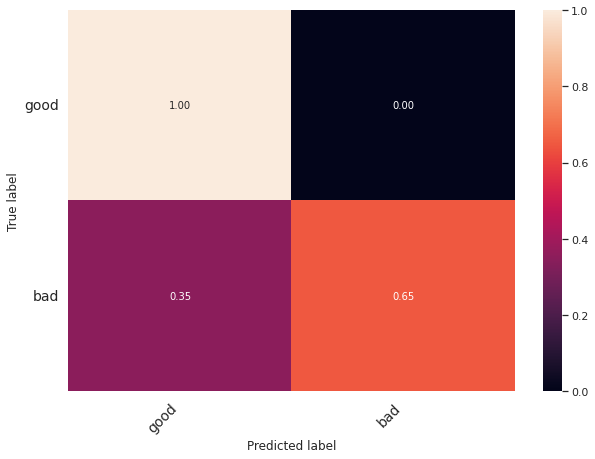

In [313]:
# Calculate probability
XGBClassTest = XGB_creditcard.predict(test_nwe.drop(['TARGET_LABEL_BAD=1'],axis=1))
xg_probs_test = XGB_creditcard.predict_proba(test_nwe.drop(['TARGET_LABEL_BAD=1'],axis=1))
xg_probs_test = xg_probs_test[:, 1]
preds_th_rf = [1 if i>=0.48 else 0 for i in xg_probs_test]

# Calculate confusion matrix
confusion_matrix_xgb = confusion_matrix(y_true = preds_th_rf, 
                    y_pred = XGBClassTest)

# Turn matrix to percentages
confusion_matrix_xgb = confusion_matrix_xgb.astype('float') / confusion_matrix_xgb.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_xgb, index=['good', 'bad'], columns=['good', 'bad'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

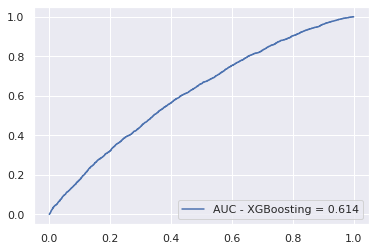

In [ ]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(test_nwe['TARGET_LABEL_BAD=1'],xg_probs_test)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = test_nwe['TARGET_LABEL_BAD=1'], 
                             y_score = xg_probs_test),
               decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="AUC - XGBoosting = " + str(auc))
plt.legend(loc=4)
plt.show()

## 2.13. VIF COMPARISON



#### 2.13.1. Random Forest Classifer

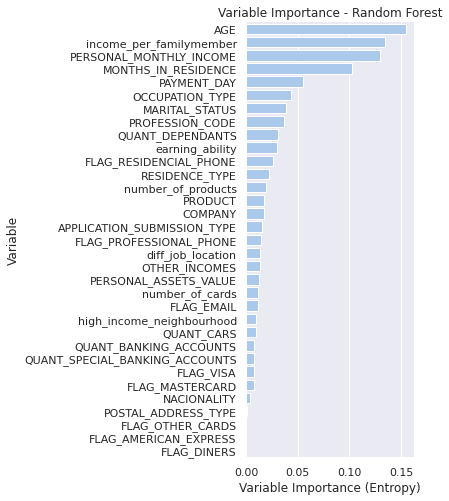

In [ ]:
# Plot variable importance
importances = Cards_RF.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - Random Forest")
sns.set_color_codes("pastel")
sns.barplot(y=[train_nwe.drop(['TARGET_LABEL_BAD=1'],axis=1).columns[i] for i in indices], 
            x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Entropy)")
sns.despine(left=True, bottom=True)

#### XG Boost Classifier


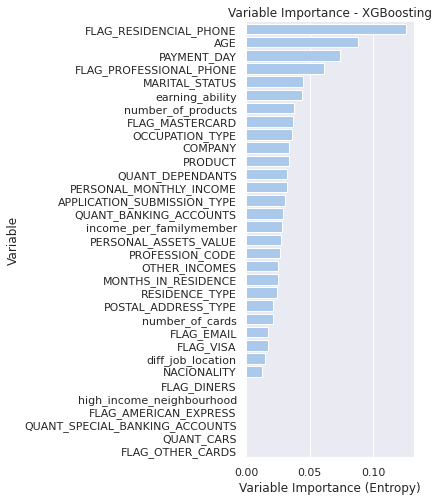

In [ ]:
# Plot variable importance
importances = XGB_creditcard.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y=[train_nwe.drop(['TARGET_LABEL_BAD=1'],axis=1).columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Entropy)")
sns.despine(left=True, bottom=True)


## 2.14. TWO-POINT CUTOFF STRATEGY


In [266]:
cutoff_df = test_PMI[['TARGET_LABEL_BAD=1','PERSONAL_MONTHLY_INCOME']]
cutoff_df['prediction_prob'] = cards_logReg.predict_proba(test_final_X)[:,1]
cutoff_df['cred_risk_score'] = test_score

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [267]:
bins = [i for i in range(300,620,10)]
cutoff_df['risk_buckets'] = pd.cut(cutoff_df['cred_risk_score'], bins)
cutoff_df.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,TARGET_LABEL_BAD=1,PERSONAL_MONTHLY_INCOME,prediction_prob,cred_risk_score,risk_buckets
3,0,500.0,0.562409,399.0,"(390, 400]"
4,1,1200.0,0.426096,439.0,"(430, 440]"
5,1,500.0,0.424855,440.0,"(430, 440]"
21,0,612.0,0.452665,431.0,"(430, 440]"
26,0,350.0,0.571551,397.0,"(390, 400]"


In [268]:
cutoff_df.to_csv('risk_2point_cutoff_strategy_10.csv')

 *************************************************************************************************************